In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v6 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-22 02:05:10.775229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:05:10.775568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:05:10.809280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:05:10.809628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:05:10.809832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN_ensemble'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_ensemble_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN_ensemble/ESN_ensemble_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

In [15]:
# plot(
#     boundary_idx_arr,
#     delta_t,
#     all_data,
#     xgrid,
#     xticks_snapto=int(40*np.round((T//10)/40))
# )

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

In [17]:
# plot(
#     boundary_idx_arr,
#     delta_t,
#     all_data,
#     xgrid,
#     xticks_snapto=int(40*np.round((T//10)/40))
# )

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

In [21]:
# plot_latent_states_KS(
#     boundary_idx_arr,
#     latent_states_all,
#     delta_t,
#     dir_name_ae,
#     xticks_snapto=int(40*np.round((T//10)/40)),
#     num_yticks=11,
#     save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 10000
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [num_latent_states*100]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [3]
    rho_res = [0.6]
    usebias_Win = [False]
    alpha = [0.99]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'linear'
    use_weights_post_dense = False
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    num_ensemble_mems = 20
    epochs = 1
    lambda_reg = 1e-4 # weight for regularizer
    min_delta = 1e-6
    patience = 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 1/100
    use_best = False

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (19, 10000, 16)
 testing_data_rnn_input.shape :  (3, 10000, 16)
     val_data_rnn_input.shape :  (2, 10000, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ensemble_lst = []
    for i in range(num_ensemble_mems):
        rnn_net = ESN(
            data_dim=data_dim,
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            ESN_layers_units=ESN_layers_units,
            stddev=stddev,
            noise_type=noise_type,
            stateful=stateful,
            omega_in=omega_in,
            sparsity=sparsity,
            rho_res=rho_res,
            usebias_Win=usebias_Win,
            alpha=alpha,
            ESN_cell_activations=ESN_cell_activations,
            prng_seed=prng_seed,
            usebias_Wout=usebias_Wout,
            use_weights_post_dense=use_weights_post_dense,
            activation_post_Wout=activation_post_Wout,
            scalar_weights=[],
        )
        rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
        rnn_net.save_class_dict(save_path+dir_sep+'{}_final_net_class_dict.txt'.format(i))
        ensemble_lst.append(rnn_net)
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.003306623697280884


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
def invert_fn(y):
    # post_Wout_activation = 'linear'
    return y

# def invert_fn(y):
#     # post_Wout_activation = 'tanh'
#     y = np.where(y < 1.0, y, 1-1e-6)
#     y = np.where(y > -1.0, y, -1+1e-6)
#     y = 0.5*(np.log(1+y) - np.log(1-y))
#     return y
    

In [33]:
training_data_rnn_input.dtype

dtype('float32')

In [34]:
for i_en in range(num_ensemble_mems):
    print('--- ENSEMBLE MEMBER {}/{} ---'.format(i_en+1, num_ensemble_mems))
    rnn_net = ensemble_lst[i_en]
    # compiling the network
    rnn_net.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=losses.MeanSquaredError(),
        metrics=['mse'],
        run_eagerly=False
    )

    lambda_reg = float(lambda_reg)

    if behaviour == 'loadCheckpointAndContinueTraining':
        # this loads the weights/attributes of the optimizer as well
        rnn_net.load_weights(wt_file)

    if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

        Wout_best = 0
        val_mse_best = np.inf
        Wout_candidate = 0
        wait = 0
        if use_weights_post_dense == True:
            postWout_candidate = 0
            h_activation = tf.keras.activations.get(activation_post_Wout)


        hidden_units = ESN_layers_units[-1]
        output_units = rnn_net.data_dim

        Hb_shape = [hidden_units, hidden_units]
        Yb_shape = [output_units, hidden_units]
        if usebias_Wout == True:
            Hb_shape[0] += 1
            Hb_shape[1] += 1
            Yb_shape[1] += 1

        Hb = np.zeros(shape=Hb_shape, dtype=FTYPE)
        Yb = np.zeros(shape=Yb_shape, dtype=FTYPE)
        eye_Hb = np.eye(Hb.shape[0], dtype=FTYPE)

        num_batches = training_data_rnn_input.shape[0]


        for i in range(epochs):
            # for layer in rnn_net.ESN_layers:
            #     layer.reset_states()

            epoch_totaltime = time.time()

            total_s_len = 80
            sep_lr_s = ' EPOCH : {} '.format(i+1)
            sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
            sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
            print('\n\n' + '-'*len(sep_lr_s))
            print('\n' + sep_lr_s+'\n')
            print('-'*len(sep_lr_s) + '\n\n')

            # '''
            ### computing Wout
            Hb[:, :] = 0
            Yb[:, :] = 0
            epoch_time = time.time()
            avg_time = 0.
            num_runs = training_data_rnn_input.shape[0]
            for j in range(num_runs):
                batch_time = time.time()
                h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
                # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                # print(h.shape)
                h = h[0]
                # y = tf.constant(training_data_rnn_output[j])
                y = invert_fn(training_data_rnn_output[j])
                if usebias_Wout == True:
                    h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
                Hb = Hb + np.matmul(np.transpose(h), h)
                Yb = Yb + np.matmul(np.transpose(y), h)
                # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)
                batch_time = time.time() - batch_time
                avg_time = (avg_time*j + batch_time)/(j+1)
                eta = avg_time * (num_runs-1 - j)
                print('{} / {} -- Wout batch_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
                    j+1,
                    num_runs,
                    batch_time,
                    float(eta // 3600),
                    float((eta%3600)//60),
                    float((eta%3600)%60),
                ))

            Wout = np.matmul(
                Yb,
                np.linalg.inv(Hb + lambda_reg*np.eye(Hb.shape[0]))
            )
            Wout = np.transpose(Wout)
            # Wout = tf.linalg.matmul(
            #     Yb,
            #     tf.linalg.inv(Hb + lambda_reg*tf.eye(Hb.shape[0]))
            # )
            # Wout = tf.transpose(Wout)

            if use_weights_post_dense == True:
                ### computing postWout
                HYb = 0
                HHb = 0
                for j in range(training_data_rnn_input.shape[0]):
                    batch_time = time.time()
                    h = np.array(rnn_net(training_data_rnn_input[j:j+1], training=True))
                    # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                    # print(h.shape)
                    h = h[0]
                    h = np.matmul(h, Wout[0:ESN_layers_units[-1], :])
                    if usebias_Wout == True:
                        h = h + Wout[ESN_layers_units[-1]:, :]
                    # y = tf.constant(training_data_rnn_output[j])
                    h = np.array(h_activation(h))
                    y = training_data_rnn_output[j]
                    HYb = HYb + np.sum(h*y, axis=0)
                    HHb = HHb + np.sum(h**2, axis=0)
                    # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                    # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

                    print('{} / {} -- postWout batch_time : {} sec'.format(
                        j+1,
                        training_data_rnn_input.shape[0],
                        time.time() - batch_time
                    ))

                postWout = HYb / (HHb + lambda_reg)

            print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

            '''
            epoch_time = time.time()
            Wout = batched_computation(
                num_batches,
                rnn_net,
                training_data_rnn_input,
                training_data_rnn_output,
                usebias_Wout,
                Hb, Yb,
                hidden_units, output_units,
                lambda_reg, eye_Hb)
            print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

            Hb[:, :] = 0.0
            Yb[:, :] = 0.0
            '''

            Wout_candidate = Wout_candidate*i/(i+1) + Wout*1/(i+1)
            tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_candidate[0:ESN_layers_units[-1], :])
            if usebias_Wout == True:
                tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_candidate[-1, :])

            if use_weights_post_dense == True:
                postWout_candidate = postWout_candidate*i/(i+1) + postWout*1/(i+1)
                tf.keras.backend.set_value(rnn_net.postWout.individual_weights, postWout_candidate)

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

            print('\nval mse')
            # '''
            val_mse = 0
            for j in range(val_data_rnn_input.shape[0]):
                batch_time = time.time()
                val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], training=False))
                temp = (val_pred - val_data_rnn_output[j:j+1])**2
                temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
                temp = np.mean(temp, axis=-1)
                temp = np.mean(temp, axis=-1)
                val_mse = val_mse*j/(j+1) + temp*1/(j+1)
                print('{} / {} -- batch_time : {} sec'.format(
                    j+1,
                    val_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
            '''
            mse_time = time.time()
            val_mse = compute_mse(
                val_data_rnn_input,
                val_data_rnn_output,
                rnn_net)
            mse_time = time.time() - mse_time
            print('val_mse compute time : {} sec'.format(mse_time))
            '''

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

            print('\ntraining mse')
            # '''
            train_mse = 0
            for j in range(training_data_rnn_input.shape[0]):
                batch_time = time.time()
                train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], training=False))
                temp = (train_pred - training_data_rnn_output[j:j+1])**2
                temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
                temp = np.mean(temp, axis=-1)
                temp = np.mean(temp, axis=-1)
                train_mse = train_mse*j/(j+1) + temp*1/(j+1)
                print('{} / {} -- batch_time : {} sec'.format(
                    j+1,
                    training_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
            '''
            mse_time = time.time()
            train_mse = compute_mse(
                training_data_rnn_input,
                training_data_rnn_output,
                rnn_net)
            mse_time = time.time() - mse_time
            print('train_mse compute time : {} sec'.format(mse_time))
            '''

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

    #         print('\ntesting mse')
    #         test_mse = 0
    #         for j in range(testing_data_rnn_input.shape[0]):
    #             print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    #             test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
    #             temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    #             temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    #             temp = np.mean(temp, axis=-1)
    #             temp = np.mean(temp, axis=-1)
    #             test_mse = test_mse*j/(j+1) + temp*1/(j+1)

    #         for layer in rnn_net.ESN_layers:
    #             layer.reset_states()

            val_loss_hist.append(val_mse)
            train_loss_hist.append(train_mse)

            # print('\ntest_mse : {}'.format(test_mse))
            print('\ntrain_mse : {}'.format(train_mse))
            print('val_mse : {}'.format(val_mse))
            if val_mse + min_delta <= val_mse_best:
                print('val_mse improved from {}'.format(val_mse_best))
                Wout_best = Wout_candidate
                val_mse_best = val_mse
                wait = 0
            else:
                wait += 1
                print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

            print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))

            if wait >= patience:
                print('\nearly stopping')
                break

    #         val_loss_hist.extend(history.history['val_loss'])
    #         train_loss_hist.extend(history.history['loss'])

    #         if i == starting_lr_idx:
    #             lr_change[i+1] += len(history.history['val_loss'])
    #         else:
    #             lr_change.append(lr_change[i]+len(history.history['val_loss']))

    # tf.keras.backend.set_value(rnn_net.Wout, Wout_best)

    if use_best == True:
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_best[0:ESN_layers_units[-1], :])
        if usebias_Wout == True:
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_best[-1, :])
    print('\ntest mse')
    test_mse = 0
    for j in range(testing_data_rnn_input.shape[0]):
        print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
        test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
        temp = (test_pred - testing_data_rnn_output[j:j+1])**2
        temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
        temp = np.mean(temp, axis=-1)
        temp = np.mean(temp, axis=-1)
        test_mse = test_mse*j/(j+1) + temp*1/(j+1)
    print('test_mse : {}'.format(test_mse))

    for layer in rnn_net.ESN_layers:
        layer.reset_states()
        
    with open(save_path+dir_sep+'{}_losses.txt'.format(i_en), 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
#             'lr_change':lr_change,
            'test_loss':test_mse
        }))


    rnn_net.save_everything(
        file_name=save_path+dir_sep+'{}_final_net'.format(i_en))
    
    # # plotting losses
    # dir_name_plot = dir_name_rnn+dir_sep+'plots'
    # if not os.path.isdir(dir_name_plot):
    #     os.makedirs(dir_name_plot)

    # # Visualize loss history
    # fig, ax = plot_losses(
    #     training_loss=train_loss_hist,
    #     val_loss=val_loss_hist,
    #     lr_change=None,
    #     learning_rate_list=None
    # )

    # plt.savefig(dir_name_rnn+'{ds}plots{ds}{oo}_loss_history.png'.format(ds=dir_sep, oo=i_en), dpi=300, bbox_inches='tight')
    # plt.show()


--- ENSEMBLE MEMBER 1/20 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 19 -- Wout batch_time : 2.06 s -- eta : 0h 0m 37s
2 / 19 -- Wout batch_time : 1.81 s -- eta : 0h 0m 33s
3 / 19 -- Wout batch_time : 1.81 s -- eta : 0h 0m 30s
4 / 19 -- Wout batch_time : 2.16 s -- eta : 0h 0m 29s
5 / 19 -- Wout batch_time : 1.69 s -- eta : 0h 0m 27s
6 / 19 -- Wout batch_time : 2.01 s -- eta : 0h 0m 25s
7 / 19 -- Wout batch_time : 1.76 s -- eta : 0h 0m 23s
8 / 19 -- Wout batch_time : 1.78 s -- eta : 0h 0m 21s
9 / 19 -- Wout batch_time : 1.87 s -- eta : 0h 0m 19s
10 / 19 -- Wout batch_time : 1.77 s -- eta : 0h 0m 17s
11 / 19 -- Wout batch_time : 1.84 s -- eta : 0h 0m 15s
12 / 19 -- Wout batch_time : 1.78 s -- eta : 0h 0m 13s
13 / 19 -- Wout batch_time : 1.86 s -- eta : 0h 0m 11s
14 / 19 -- Wout 

7 / 19 -- Wout batch_time : 1.86 s -- eta : 0h 0m 23s
8 / 19 -- Wout batch_time : 1.87 s -- eta : 0h 0m 21s
9 / 19 -- Wout batch_time : 1.89 s -- eta : 0h 0m 19s
10 / 19 -- Wout batch_time : 1.86 s -- eta : 0h 0m 17s
11 / 19 -- Wout batch_time : 1.90 s -- eta : 0h 0m 15s
12 / 19 -- Wout batch_time : 2.02 s -- eta : 0h 0m 13s
13 / 19 -- Wout batch_time : 1.88 s -- eta : 0h 0m 11s
14 / 19 -- Wout batch_time : 1.98 s -- eta : 0h 0m 10s
15 / 19 -- Wout batch_time : 1.98 s -- eta : 0h 0m 8s
16 / 19 -- Wout batch_time : 1.96 s -- eta : 0h 0m 6s
17 / 19 -- Wout batch_time : 1.94 s -- eta : 0h 0m 4s
18 / 19 -- Wout batch_time : 2.05 s -- eta : 0h 0m 2s
19 / 19 -- Wout batch_time : 1.91 s -- eta : 0h 0m 0s

epoch_time : 36.99642467498779 sec

val mse
1 / 2 -- batch_time : 1.3438234329223633 sec
2 / 2 -- batch_time : 1.3964183330535889 sec

training mse
1 / 19 -- batch_time : 1.2207839488983154 sec
2 / 19 -- batch_time : 1.3387842178344727 sec
3 / 19 -- batch_time : 1.2594945430755615 sec
4 / 19

18 / 19 -- Wout batch_time : 1.78 s -- eta : 0h 0m 2s
19 / 19 -- Wout batch_time : 1.82 s -- eta : 0h 0m 0s

epoch_time : 35.755494832992554 sec

val mse
1 / 2 -- batch_time : 1.351581335067749 sec
2 / 2 -- batch_time : 1.2837610244750977 sec

training mse
1 / 19 -- batch_time : 1.2816174030303955 sec
2 / 19 -- batch_time : 1.3965907096862793 sec
3 / 19 -- batch_time : 1.2501380443572998 sec
4 / 19 -- batch_time : 1.2820093631744385 sec
5 / 19 -- batch_time : 1.2158751487731934 sec
6 / 19 -- batch_time : 1.3082170486450195 sec
7 / 19 -- batch_time : 1.3133714199066162 sec
8 / 19 -- batch_time : 1.306363821029663 sec
9 / 19 -- batch_time : 1.3305788040161133 sec
10 / 19 -- batch_time : 1.2474806308746338 sec
11 / 19 -- batch_time : 1.3177437782287598 sec
12 / 19 -- batch_time : 1.26731538772583 sec
13 / 19 -- batch_time : 1.3065874576568604 sec
14 / 19 -- batch_time : 1.257323980331421 sec
15 / 19 -- batch_time : 1.2558612823486328 sec
16 / 19 -- batch_time : 1.3968517780303955 sec
17 /

8 / 19 -- batch_time : 1.2387101650238037 sec
9 / 19 -- batch_time : 1.236584186553955 sec
10 / 19 -- batch_time : 1.282029628753662 sec
11 / 19 -- batch_time : 1.349184513092041 sec
12 / 19 -- batch_time : 1.3396904468536377 sec
13 / 19 -- batch_time : 1.2737200260162354 sec
14 / 19 -- batch_time : 1.2258014678955078 sec
15 / 19 -- batch_time : 1.3395118713378906 sec
16 / 19 -- batch_time : 1.2272753715515137 sec
17 / 19 -- batch_time : 1.2731833457946777 sec
18 / 19 -- batch_time : 1.301072120666504 sec
19 / 19 -- batch_time : 1.2445292472839355 sec

train_mse : 5.063568742595012e-06
val_mse : 7.096465878930758e-06
val_mse improved from inf

Total epoch computation time : 62.38011360168457 sec

test mse
1 / 3
2 / 3
3 / 3
test_mse : 6.659337789945615e-06
--- ENSEMBLE MEMBER 11/20 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------

2 / 3
3 / 3
test_mse : 6.664689863100648e-06
--- ENSEMBLE MEMBER 14/20 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 19 -- Wout batch_time : 1.88 s -- eta : 0h 0m 34s
2 / 19 -- Wout batch_time : 1.83 s -- eta : 0h 0m 31s
3 / 19 -- Wout batch_time : 2.09 s -- eta : 0h 0m 31s
4 / 19 -- Wout batch_time : 1.84 s -- eta : 0h 0m 29s
5 / 19 -- Wout batch_time : 1.84 s -- eta : 0h 0m 27s
6 / 19 -- Wout batch_time : 1.81 s -- eta : 0h 0m 24s
7 / 19 -- Wout batch_time : 1.97 s -- eta : 0h 0m 23s
8 / 19 -- Wout batch_time : 1.93 s -- eta : 0h 0m 21s
9 / 19 -- Wout batch_time : 1.81 s -- eta : 0h 0m 19s
10 / 19 -- Wout batch_time : 1.87 s -- eta : 0h 0m 17s
11 / 19 -- Wout batch_time : 1.79 s -- eta : 0h 0m 15s
12 / 19 -- Wout batch_time : 1.78 s -- eta : 0h 0m 13s
13 / 19 -- Wout batch_tim

6 / 19 -- Wout batch_time : 1.80 s -- eta : 0h 0m 24s
7 / 19 -- Wout batch_time : 1.94 s -- eta : 0h 0m 23s
8 / 19 -- Wout batch_time : 2.03 s -- eta : 0h 0m 21s
9 / 19 -- Wout batch_time : 1.82 s -- eta : 0h 0m 19s
10 / 19 -- Wout batch_time : 1.85 s -- eta : 0h 0m 17s
11 / 19 -- Wout batch_time : 1.95 s -- eta : 0h 0m 15s
12 / 19 -- Wout batch_time : 1.96 s -- eta : 0h 0m 13s
13 / 19 -- Wout batch_time : 1.81 s -- eta : 0h 0m 11s
14 / 19 -- Wout batch_time : 1.79 s -- eta : 0h 0m 9s
15 / 19 -- Wout batch_time : 3.21 s -- eta : 0h 0m 8s
16 / 19 -- Wout batch_time : 4.29 s -- eta : 0h 0m 6s
17 / 19 -- Wout batch_time : 1.73 s -- eta : 0h 0m 4s
18 / 19 -- Wout batch_time : 1.85 s -- eta : 0h 0m 2s
19 / 19 -- Wout batch_time : 1.96 s -- eta : 0h 0m 0s

epoch_time : 40.024044036865234 sec

val mse
1 / 2 -- batch_time : 1.3653223514556885 sec
2 / 2 -- batch_time : 1.2051472663879395 sec

training mse
1 / 19 -- batch_time : 1.1573853492736816 sec
2 / 19 -- batch_time : 1.2933077812194824 se

17 / 19 -- Wout batch_time : 1.90 s -- eta : 0h 0m 4s
18 / 19 -- Wout batch_time : 1.93 s -- eta : 0h 0m 2s
19 / 19 -- Wout batch_time : 1.88 s -- eta : 0h 0m 0s

epoch_time : 37.2204647064209 sec

val mse
1 / 2 -- batch_time : 1.4025392532348633 sec
2 / 2 -- batch_time : 1.3662025928497314 sec

training mse
1 / 19 -- batch_time : 1.2954392433166504 sec
2 / 19 -- batch_time : 1.3450758457183838 sec
3 / 19 -- batch_time : 1.2864453792572021 sec
4 / 19 -- batch_time : 1.355736494064331 sec
5 / 19 -- batch_time : 1.3641188144683838 sec
6 / 19 -- batch_time : 1.3037598133087158 sec
7 / 19 -- batch_time : 1.394517421722412 sec
8 / 19 -- batch_time : 1.3006222248077393 sec
9 / 19 -- batch_time : 1.34580397605896 sec
10 / 19 -- batch_time : 1.29313325881958 sec
11 / 19 -- batch_time : 1.2756619453430176 sec
12 / 19 -- batch_time : 1.3578829765319824 sec
13 / 19 -- batch_time : 1.3229398727416992 sec
14 / 19 -- batch_time : 1.392204761505127 sec
15 / 19 -- batch_time : 1.3041069507598877 sec
1

In [35]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

In [36]:
def get_ensemble_prediction(ensemble_lst, inputs, kwargs={}):
    pred = 0
    for i in range(len(ensemble_lst)):
        pred += np.array(ensemble_lst[i](inputs, **kwargs))
    pred /= len(ensemble_lst)
    return pred

data_idx : 0


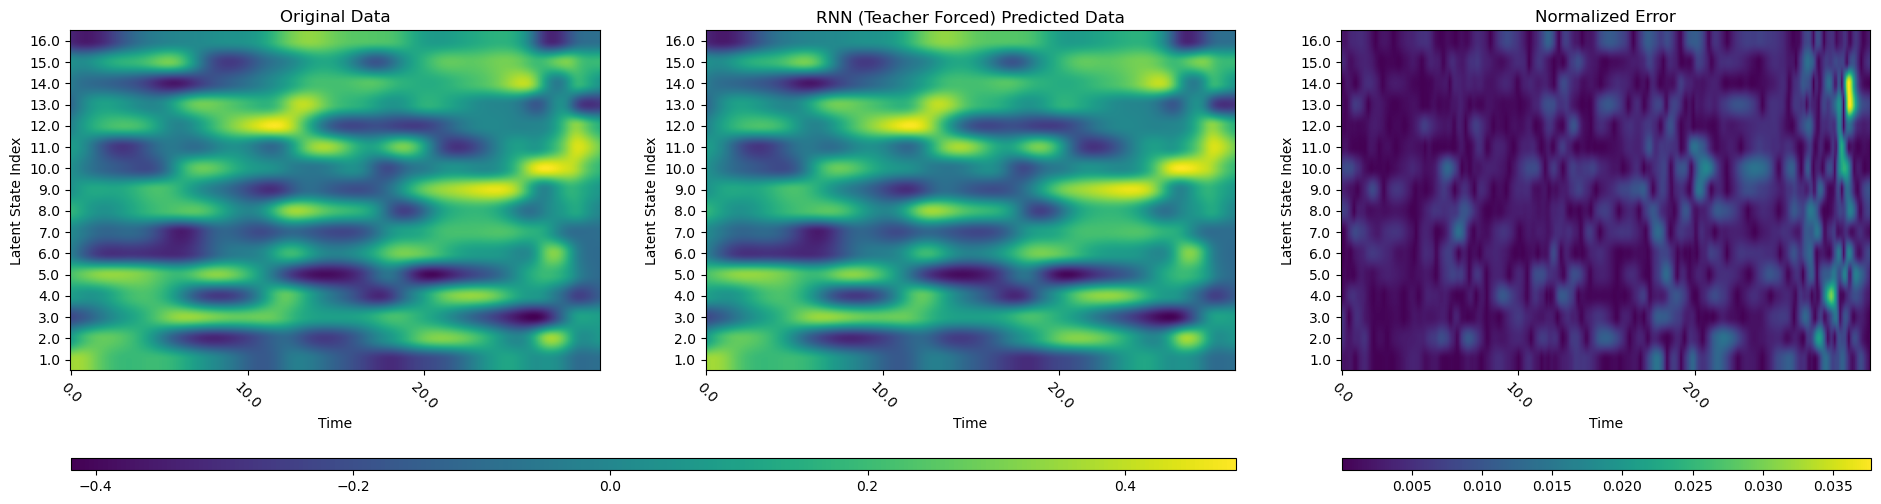

In [37]:
data_type = 'training'
# data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx, 200:200+300]

for rnn_net in ensemble_lst:
    for layer in rnn_net.ESN_layers:
        layer.reset_states()

prediction = np.array(
    get_ensemble_prediction(
        ensemble_lst,
        data_in[data_idx:data_idx+1, :, :],
        {'training':False}
    )
)[:, 200:200+300, :]

for rnn_net in ensemble_lst:
    for layer in rnn_net.ESN_layers:
        layer.reset_states()

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=10,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [38]:
prediction.shape, data_out.shape

((1, 300, 16), (300, 16))

In [39]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 0


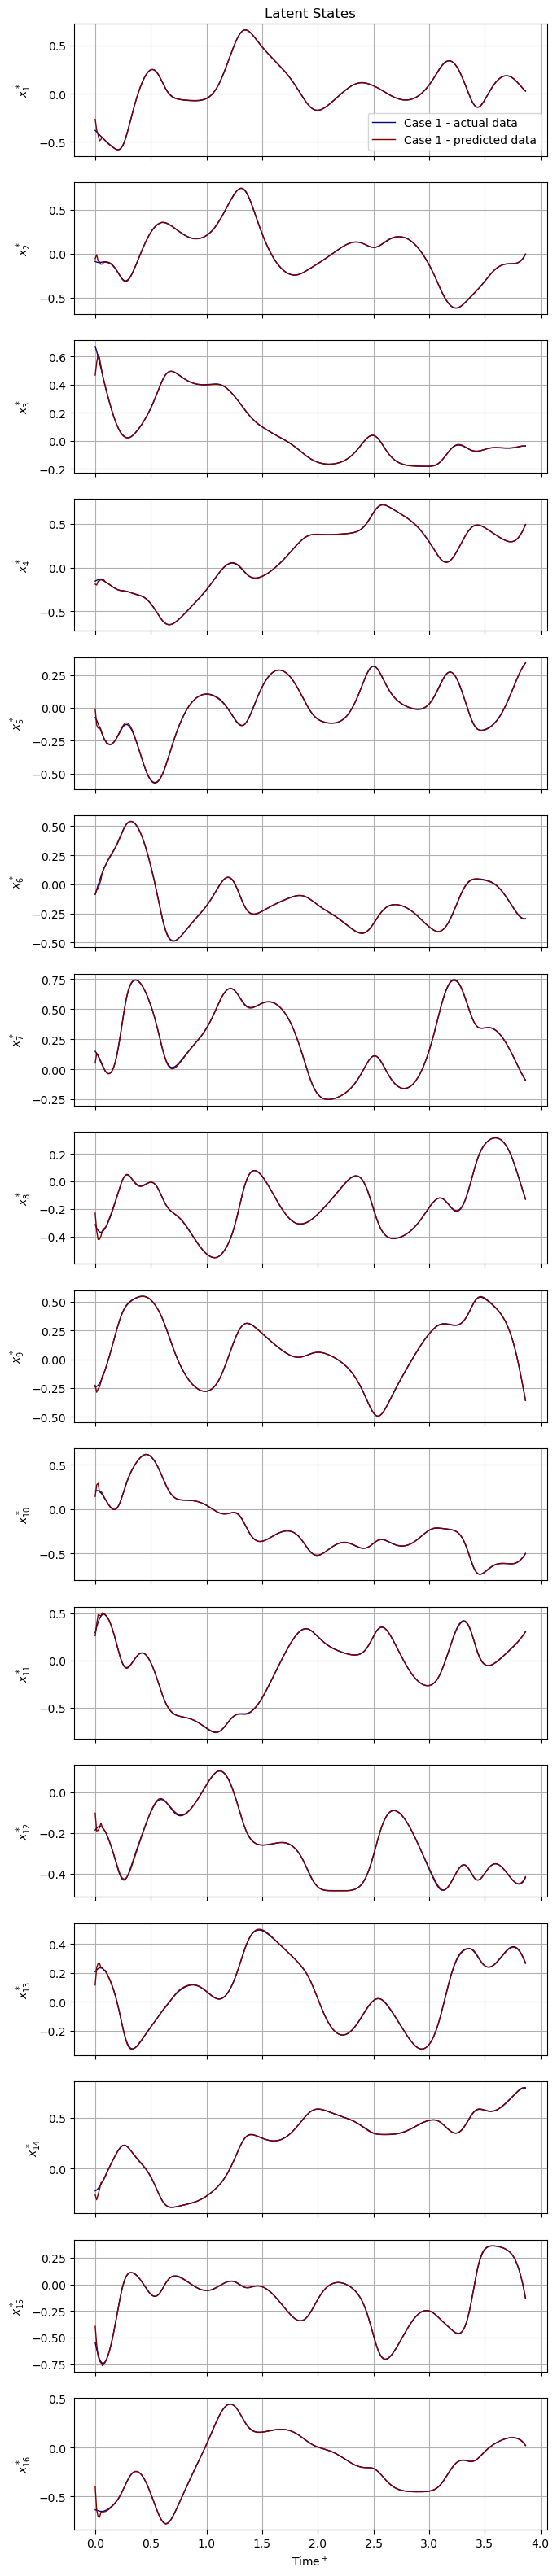


3.8664707312898243


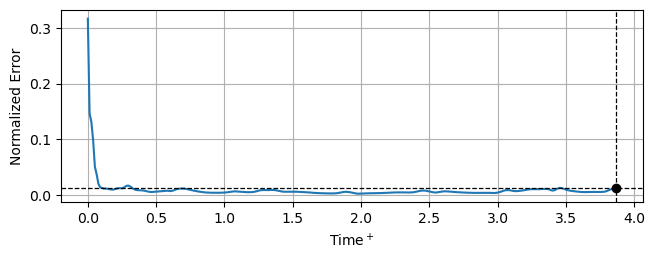

In [40]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx][0:300]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

for rnn_net in ensemble_lst:
    for layer in rnn_net.ESN_layers:
        layer.reset_states()

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
prediction = np.array(
    get_ensemble_prediction(
        ensemble_lst,
        data_in[data_idx:data_idx+1, :, :],
        {'training':False}
    )
)[:, 0:300, :]
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

for rnn_net in ensemble_lst:
    for layer in rnn_net.ESN_layers:
        layer.reset_states()

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()

# Auto Regressive ESN

In [41]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [50]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 15*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 6420
data_.shape : (1, 1237, 16)


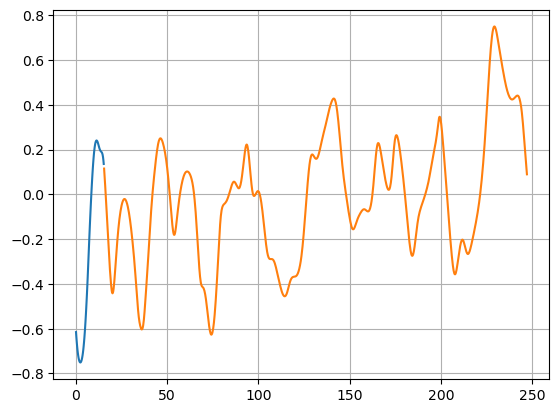

In [51]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [52]:
prediction_lst = []

for rnn_net in ensemble_lst:
    for layer in rnn_net.ESN_layers:
        layer.reset_states()
    
input_preds = np.array(get_ensemble_prediction(
    ensemble_lst,
    data_[:, 0:num_sample_input_AR, :],
    {'training':False}
))[0]

prediction_lst.append(input_preds[-1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(get_ensemble_prediction(
        ensemble_lst,
        data_in_i, 
        {'training':False}
    ))[0, 0]
    prediction_lst.append(output)

In [53]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (77, 16)
prediction_lst.shape : (1160, 16)


0.9310564971667804


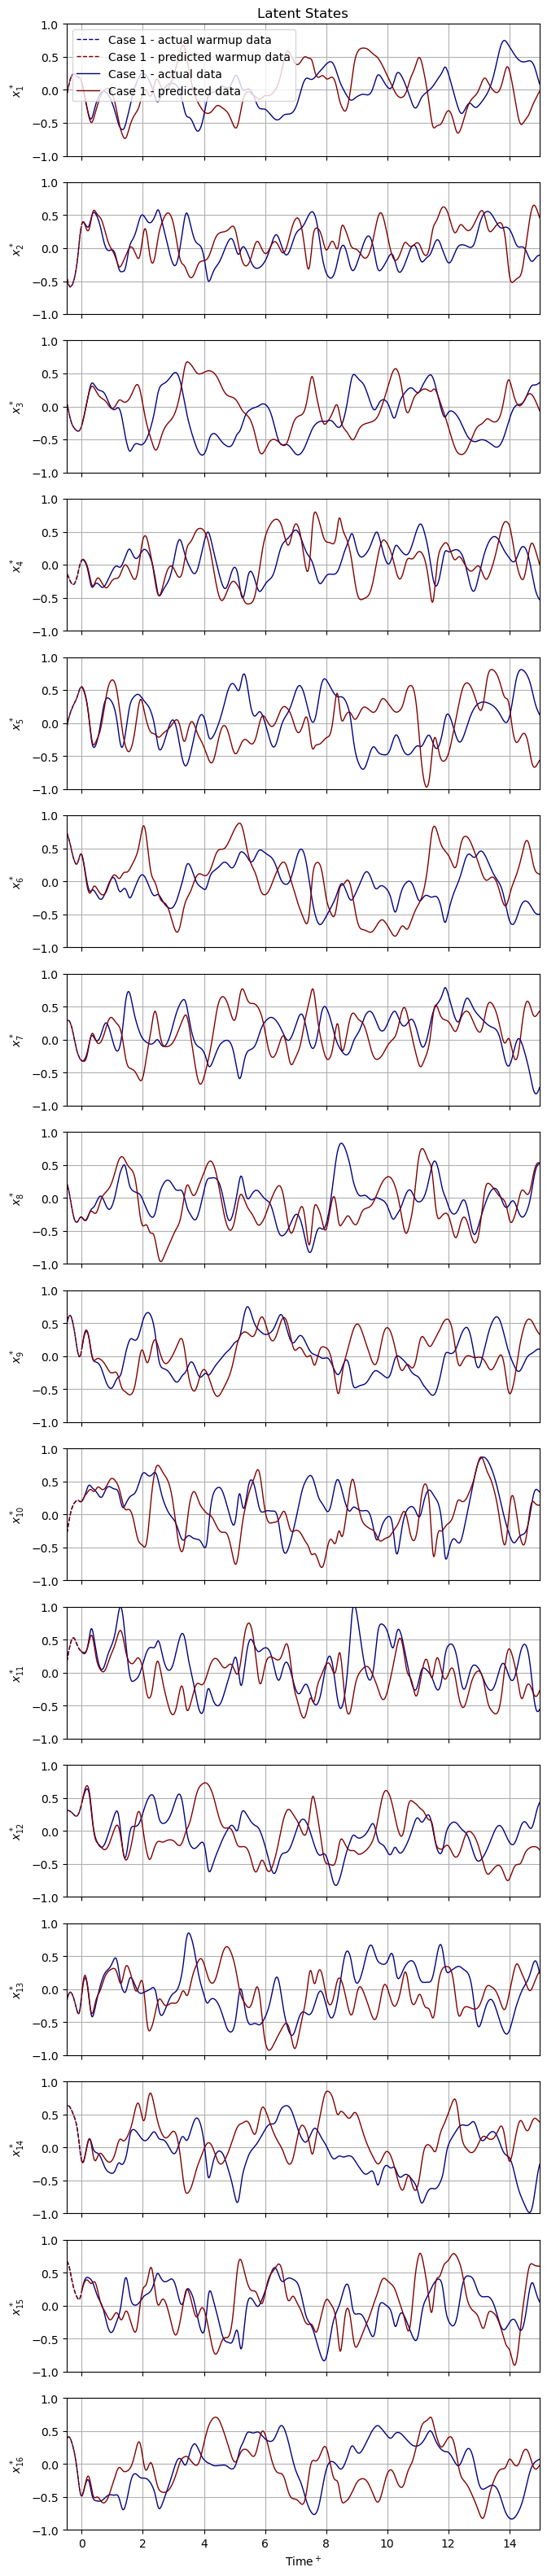

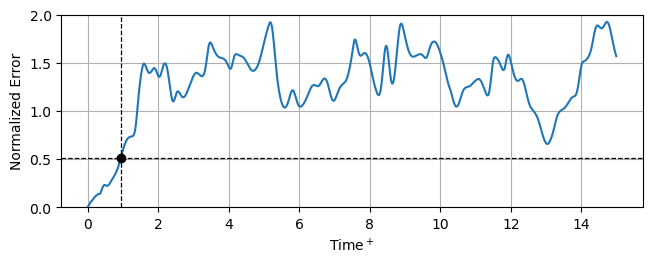

In [54]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [55]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

### Prediction horizon computation

In [48]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [49]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []
    
    for rnn_net in ensemble_lst:
        for layer in rnn_net.ESN_layers:
            layer.reset_states()

    input_preds = np.array(get_ensemble_prediction(
        ensemble_lst,
        data_[:, 0:num_sample_input_AR, :],
        {'training':False}
    ))[0]

    prediction_lst.append(input_preds[-1])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array([[prediction_lst[-1]]])
        output = np.array(get_ensemble_prediction(
            ensemble_lst,
            data_in_j,
            {'training':False}
        ))[0, 0]
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)
    # prediction_lst = invert_normalization(prediction_lst, normalization_arr)
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR, :]
    # data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

saved_ESN_ensemble/ESN_ensemble_001

error_threshold = 0.5
prediction_horizon : 1.052611095407999, median : 0.9827818581204905
ph_min : 0.4138028876296802, ph_max : 1.8750443345719883
stddev : 0.3467914471441474, IQR : 0.5172536095371001
1st quartile : 0.7758804143056504, 3rd quartile : 1.2931340238427504
analysis time : 1018.9266073703766 s

